In [104]:
# initialize dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
import random

Label: Simple_Gun_Parts


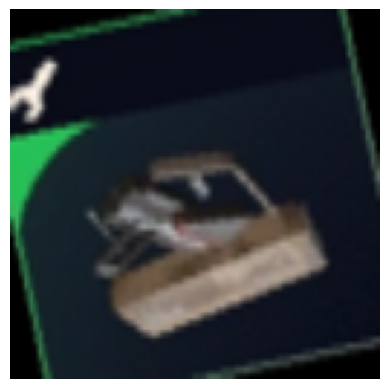

In [ ]:
# prepare datasets
# import png images from 'arc-raiders-items' folder. Label is folder name, images below are training images.
train_dataset = torchvision.datasets.ImageFolder(
    root="./arc-raiders-items",
    transform=transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    ),
)

# display random image from dataset
index = random.randrange(0, len(train_dataset) - 1)
image, label = train_dataset[index]
print(f"Label: {train_dataset.classes[label]}")

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))  # change from CxHxW to HxWxC
plt.axis("off")
plt.show()

In [106]:
# init neuralnet
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128 * 128 * 3, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, len(train_dataset.classes)),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

# move dataset to GPU if available
train_dataset = [(image.to(device), label) for image, label in train_dataset]

torch.cuda.list_gpu_processes()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=190, bias=True)
)

In [107]:
# training loop

num_epochs = 100
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # forward pass
        logits = net(images)
        loss = loss_fn(logits, labels)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

RuntimeError: Expected all tensors to be on the same device, but got target is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_nll_loss_forward)

Predicted: [154, 189, 162, 94, 185], Actual: [154, 189, 162, 94, 185]


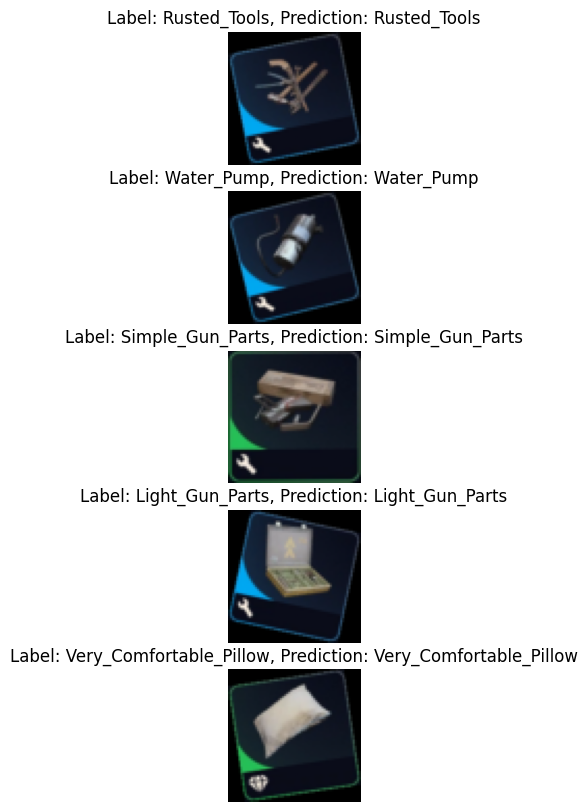

In [59]:
# predict on random images
# select random image set and predict
randomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
images = []
labels = []
for i in range(5):
    img, lbl = train_dataset[randomIndices[i]]
    images.append(img)
    labels.append(lbl)

images = torch.stack(images)  # create batch
logits = net(images)
predicted_labels = logits.argmax(dim=1).tolist()

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {predicted_labels}, Actual: {labels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[randomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0))  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = train_dataset.classes[lbl]
    predicted_label_name = train_dataset.classes[predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

In [45]:
# Save neural net weights
torch.save(net.state_dict(), "ardraiders_model.pth")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [73]:
# go through all folders in 'arc-raiders-items' and remove all images except 1.png
import os
import shutil
root_dir = "./arc-raiders-items"
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name != "1.png":
                file_path = os.path.join(folder_path, file_name)
                os.remove(file_path)

In [74]:
# go through all folders and create random transformations of 1.png to create more training images
from PIL import Image
import numpy as np
import random

root_dir = "./arc-raiders-items"
num_augmented_images = 100  # number of augmented images to create per category
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        image_path = os.path.join(folder_path, "1.png")
        if os.path.exists(image_path):
            original_image = Image.open(image_path)
            for i in range(num_augmented_images):
                # Apply random transformations
                augmented_image = original_image.rotate(random.uniform(-30, 30))  # random rotation
                augmented_image = augmented_image.resize(
                    (random.randint(50, 100), random.randint(50, 100))
                )  # random resize
                augmented_image = augmented_image.transpose(
                    random.choice([Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM])
                )  # random flip

                # Save augmented image
                augmented_image_path = os.path.join(folder_path, f"augmented_{i+1}.png")
                augmented_image.save(augmented_image_path)